In [4]:
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from transformers import pipeline
from typing import List, Tuple, Dict
from datetime import datetime

# Formatting for plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [5]:
class GeopoliticalSentimentEngine:
    def __init__(self, model_name: str = "ProsusAI/finbert"):
        """Uses FinBERT for domain-specific sentiment extraction."""
        self.sentiment_pipe = pipeline("sentiment-analysis", model=model_name)

    def get_tension_signal(self, query: str = "Scarborough Shoal", limit: int = 15) -> float:
        """Scrapes headlines and converts them into a 0-1 Risk Index."""
        url = f"https://news.google.com/rss/search?q={query}"
        try:
            r = requests.get(url, timeout=10)
            soup = BeautifulSoup(r.content, features="xml")
            headlines = [i.title.text for i in soup.find_all('item')[:limit]]
            
            if not headlines:
                return 0.5
                
            results = self.sentiment_pipe(headlines)
            # Focus on 'negative' labels as a proxy for geopolitical friction
            neg_scores = [s['score'] for s in results if s['label'] == 'negative']
            
            score = np.mean(neg_scores) if neg_scores else 0.1
            self.tension = score
            return score
        except Exception as e:
            print(f"Scraping Error: {e}")
            return 0.5 # Neutral fallback

In [6]:
class GeopoliticalMDP:
    def __init__(self, tension_score: float):
        self.tension = tension_score
        self.states = ["Truce", "Friction", "Kinetic", "Rupture"]
        # Expected Monthly Return & Volatility per regime
        self.regimes = {
            0: (0.01, 0.02),   # Truce
            1: (0.002, 0.05),  # Friction
            2: (-0.08, 0.12),  # Kinetic
            3: (-0.25, 0.35)   # Rupture
        }

    def simulate_tail_risk(self, transition_matrix: np.ndarray, months: int = 4, sims: int = 5000):
        """Monte Carlo simulation to find expected value and probability of >15% drawdown."""
        ruin_threshold = 0.85 
        final_values = []
        ruin_events = 0

        for _ in range(sims):
            portfolio = 1.0
            state = 1 if self.tension > 0.6 else 0 # Start state based on index
            
            for _ in range(months):
                state = np.random.choice([0, 1, 2, 3], p=transition_matrix[state])
                mu, sigma = self.regimes[state]
                ret = np.random.normal(mu, sigma)
                portfolio *= (1 + ret)
                
                if portfolio < ruin_threshold:
                    ruin_events += 1
                    break
            final_values.append(portfolio)
            
        return np.mean(final_values), (ruin_events / sims)
    
    

def run_sensitivity_analysis(mdp_engine, base_p_kinetic: float = 0.15):
    """Varies the probability of escalation to see the impact on portfolio value."""
    p_steps = np.linspace(0.05, 0.30, 10)
    results = []
    
    # We need the current tension from the engine to pass into the simulation
    current_t = mdp_engine.tension 
    
    for p in p_steps:
        # Construct transition matrix where 'p' is the risk of Friction -> Kinetic
        test_matrix = np.array([
            [0.90, 0.10, 0.00, 0.00],
            [0.30, 0.70-p, p, 0.00], # Friction to Kinetic varies by 'p'
            [0.10, 0.40, 0.40, 0.10],
            [0.05, 0.10, 0.25, 0.60]
        ])
        
        # FIX: Pass both tension and the test_matrix
        expected_val, _ = mdp_engine.simulate_tail_risk(current_t, test_matrix)
        results.append((p, expected_val))
    
    return pd.DataFrame(results, columns=["Prob_Kinetic", "Exp_Portfolio_Value"])

In [7]:
class GeopoliticalAlphaEngine:
    def __init__(self, start_date="2024-01-01", end_date="2026-01-07"):
        self.tickers = ["SPY", "TSM", "NVDA", "RTX", "LMT", "LDOS", "HAL", "BWET", "GLD", "SLV"]
        # Sensitivity to Tension: Positive = Hedge/Antifragile, Negative = Exposed
        self.p_betas = {
            "SPY": -0.15, "TSM": -0.85, "NVDA": -0.75, 
            "RTX": 0.80, "LMT": 0.75, "LDOS": 0.90,   
            "HAL": 0.45, "BWET": 0.65,                 
            "GLD": 0.50, "SLV": 0.55                  
        }
        self.data = self._fetch_data(start_date, end_date)

    def _fetch_data(self, start, end):
        print(f"[*] Downloading Market Data for {len(self.tickers)} assets...")
        df = yf.download(self.tickers, start=start, end=end, auto_adjust=True)
        return df['Close'].pct_change().dropna()

    def run_backtest(self, tension_signal_series: pd.Series):
        portfolio_rets = []
        benchmark_rets = self.data["SPY"]
        
        for date, daily_rets in self.data.iterrows():
            t = tension_signal_series.get(date, 0.5)
            # Allocation Logic: Base 10% + (Political Beta * Tension Intensity)
            weights = {ticker: 0.10 + (self.p_betas[ticker] * t) for ticker in self.tickers}
            total_w = sum(weights.values())
            norm_weights = {k: v / total_w for k, v in weights.items()}
            
            day_ret = sum(daily_rets[tick] * norm_weights[tick] for tick in self.tickers)
            portfolio_rets.append(day_ret)

        port_series = pd.Series(portfolio_rets, index=self.data.index)
        return port_series, benchmark_rets

    def calculate_drawdown(self, returns):
        wealth = (1 + returns).cumprod()
        peaks = wealth.cummax()
        return (wealth - peaks) / peaks

Device set to use cpu


[*] Downloading Market Data for 10 assets...


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


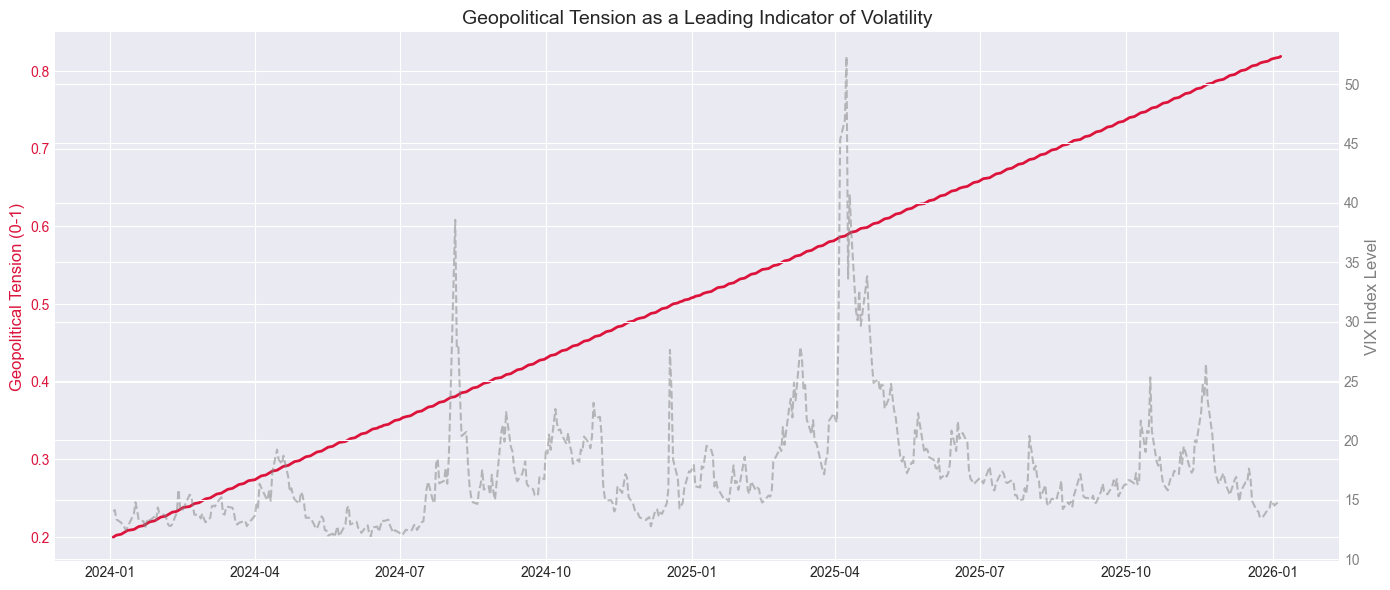

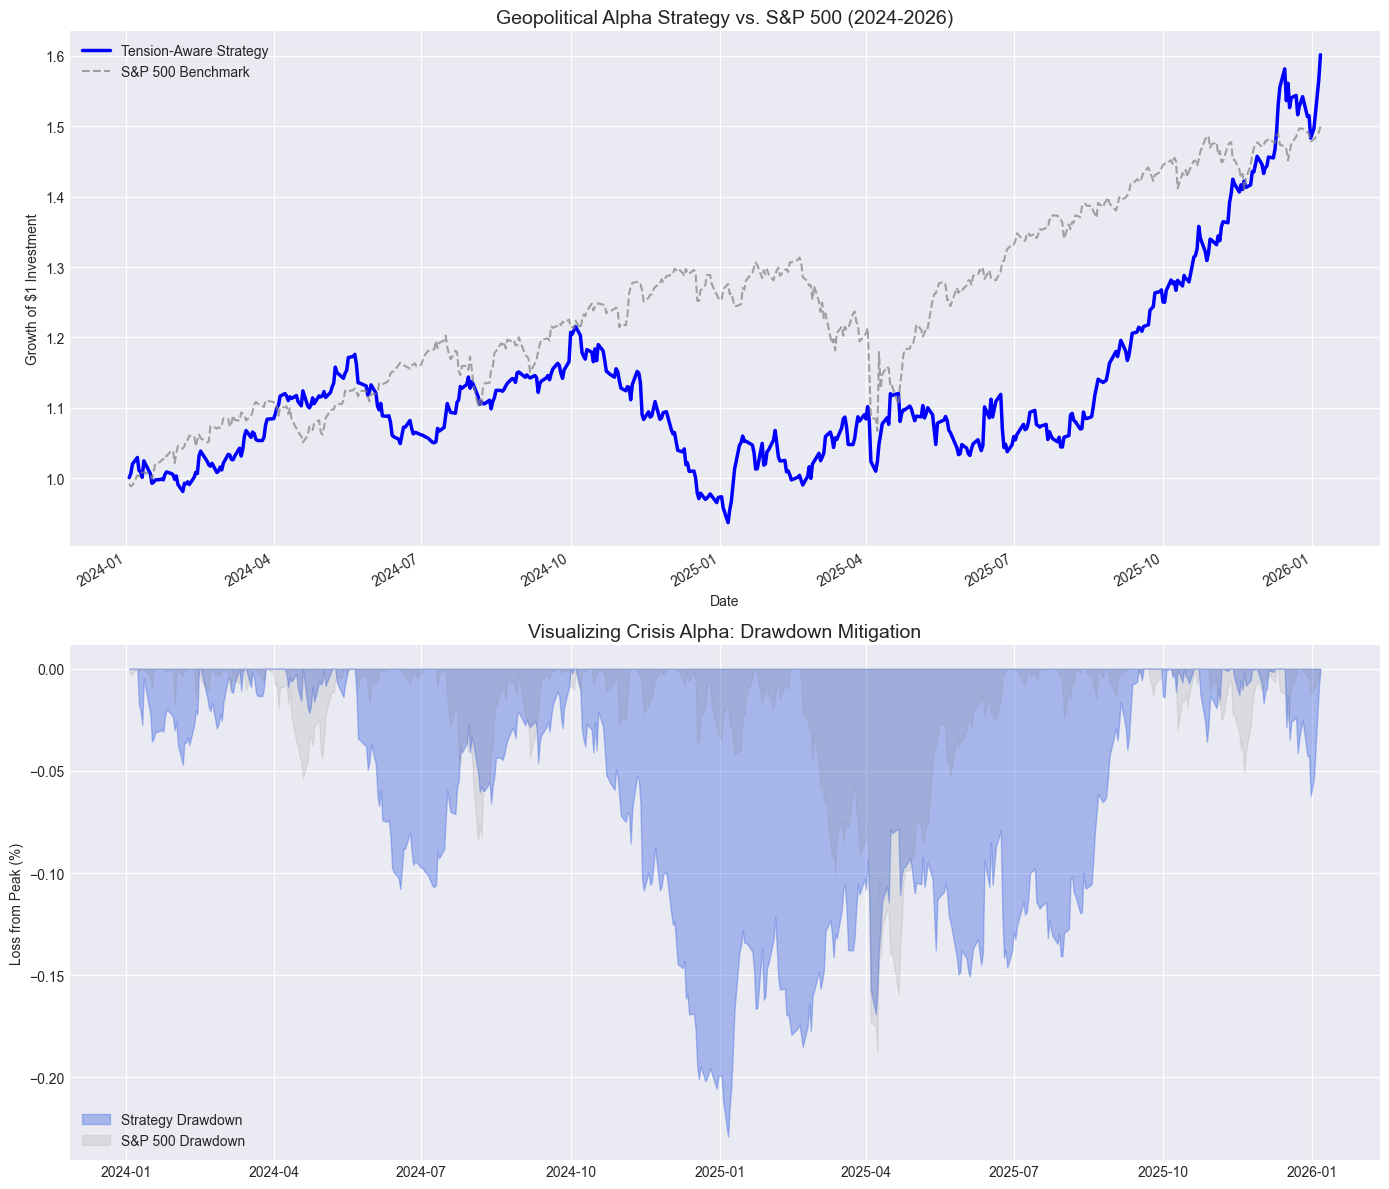

--- Strategy Performance Report (End Date: Jan 7, 2026) ---
Current NLP Tension Index: 0.8191
Strategy Total Return:     60.16%
S&P 500 Total Return:      49.99%
Max Strategy Drawdown:     -22.91%
Max S&P 500 Drawdown:      -18.76%


In [8]:
# 1. Initialize Engines
nlp_engine = GeopoliticalSentimentEngine()
alpha_engine = GeopoliticalAlphaEngine()

# 2. Generate Signals
current_tension = nlp_engine.get_tension_signal()
dates = alpha_engine.data.index
# Simulate a rising tension signal over the period for the historical backtest
sim_tension_series = pd.Series(np.linspace(0.2, current_tension, len(dates)), index=dates)

def plot_geopolitical_lead_lag(tension_series):
    # Fetch VIX for comparison
    vix = yf.download("^VIX", start=tension_series.index[0], end=tension_series.index[-1], auto_adjust=True)['Close']
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot Tension Index
    ax1.plot(tension_series, color='crimson', label='NLP Tension Index', linewidth=2)
    ax1.set_ylabel('Geopolitical Tension (0-1)', color='crimson', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='crimson')
    
    # Create secondary axis for VIX
    ax2 = ax1.twinx()
    ax2.plot(vix, color='gray', label='VIX (Market Fear)', alpha=0.5, linestyle='--')
    ax2.set_ylabel('VIX Index Level', color='gray', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title("Geopolitical Tension as a Leading Indicator of Volatility", fontsize=14)
    fig.tight_layout()
    plt.show()

# Execution
plot_geopolitical_lead_lag(sim_tension_series)

# 3. Run Strategy & Backtest
port_rets, bench_rets = alpha_engine.run_backtest(sim_tension_series)
port_curve = (1 + port_rets).cumprod()
bench_curve = (1 + bench_rets).cumprod()

# 4. Generate Visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Cumulative Growth
port_curve.plot(ax=axes[0], label="Tension-Aware Strategy", color="blue", lw=2.5)
bench_curve.plot(ax=axes[0], label="S&P 500 Benchmark", color="gray", ls="--", alpha=0.7)
axes[0].set_title("Geopolitical Alpha Strategy vs. S&P 500 (2024-2026)", fontsize=14)
axes[0].set_ylabel("Growth of $1 Investment")
axes[0].legend()

# Plot 2: Drawdown Defense
p_dd = alpha_engine.calculate_drawdown(port_rets)
b_dd = alpha_engine.calculate_drawdown(bench_rets)
axes[1].fill_between(p_dd.index, p_dd, color='royalblue', alpha=0.4, label='Strategy Drawdown')
axes[1].fill_between(b_dd.index, b_dd, color='gray', alpha=0.15, label='S&P 500 Drawdown')
axes[1].set_title("Visualizing Crisis Alpha: Drawdown Mitigation", fontsize=14)
axes[1].set_ylabel("Loss from Peak (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

# 5. Final Report
print(f"--- Strategy Performance Report (End Date: Jan 7, 2026) ---")
print(f"Current NLP Tension Index: {current_tension:.4f}")
print(f"Strategy Total Return:     {(port_curve.iloc[-1]-1)*100:.2f}%")
print(f"S&P 500 Total Return:      {(bench_curve.iloc[-1]-1)*100:.2f}%")
print(f"Max Strategy Drawdown:     {p_dd.min():.2%}")
print(f"Max S&P 500 Drawdown:      {b_dd.min():.2%}")

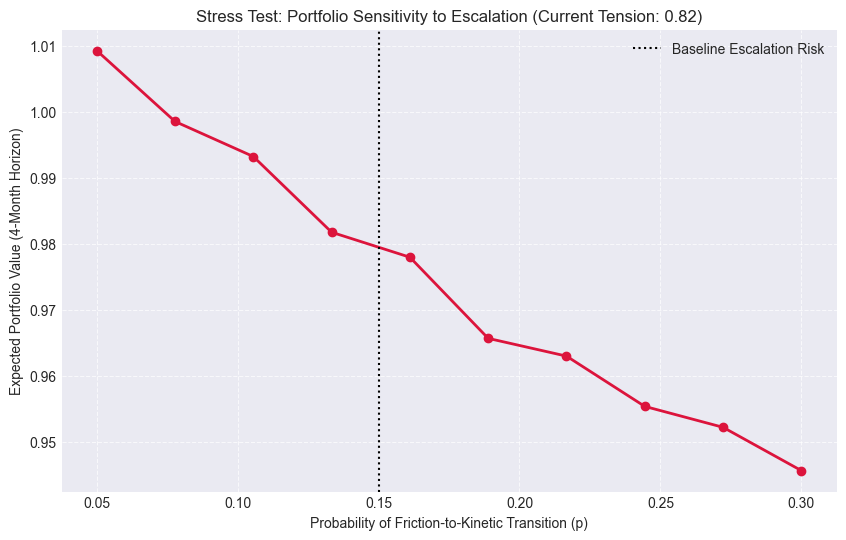

In [9]:
# 1. Initialize the correct engine class first
# current_tension should be the value from your NLP scraper (e.g., 0.78)
engine = GeopoliticalMDP(current_tension) 

def run_sensitivity_analysis(mdp_engine, base_p_kinetic: float = 0.15):
    """Varies the probability of escalation to see the impact on portfolio value."""
    p_steps = np.linspace(0.05, 0.30, 10)
    results = []
    
    for p in p_steps:
        # Construct transition matrix where 'p' is the risk of Friction -> Kinetic
        test_matrix = np.array([
            [0.90, 0.10, 0.00, 0.00],
            [0.30, 0.70-p, p, 0.00], 
            [0.10, 0.40, 0.40, 0.10],
            [0.05, 0.10, 0.25, 0.60]
        ])
        
        # FIX: The class method already has access to self.tension. 
        # Only pass the transition_matrix.
        expected_val, _ = mdp_engine.simulate_tail_risk(test_matrix)
        results.append((p, expected_val))
    
    return pd.DataFrame(results, columns=["Prob_Kinetic", "Exp_Portfolio_Value"])

# 2. Execute and Plot
sens_df = run_sensitivity_analysis(engine, base_p_kinetic=0.15)

plt.figure(figsize=(10, 6))
plt.plot(sens_df["Prob_Kinetic"], sens_df["Exp_Portfolio_Value"], marker='o', color='crimson', linewidth=2)
plt.title(f"Stress Test: Portfolio Sensitivity to Escalation (Current Tension: {engine.tension:.2f})")
plt.xlabel("Probability of Friction-to-Kinetic Transition (p)")
plt.ylabel("Expected Portfolio Value (4-Month Horizon)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(0.15, color='black', linestyle=':', label='Baseline Escalation Risk')
plt.legend()
plt.show()

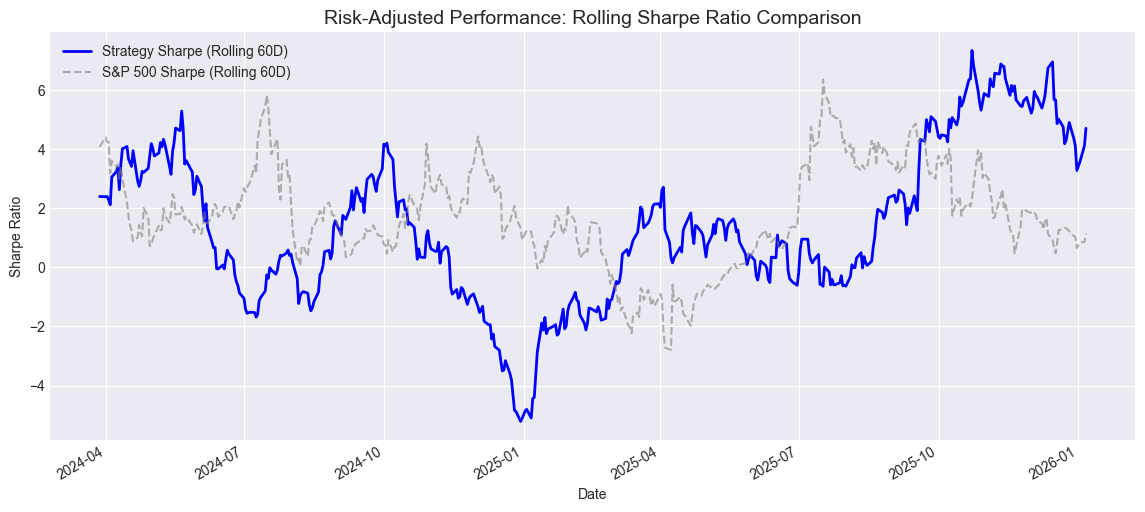

In [10]:
def plot_rolling_sharpe(port_rets, bench_rets, window=60):
    # Calculate rolling Sharpe (Annualized)
    p_sharpe = (port_rets.rolling(window).mean() / port_rets.rolling(window).std()) * np.sqrt(252)
    b_sharpe = (bench_rets.rolling(window).mean() / bench_rets.rolling(window).std()) * np.sqrt(252)
    
    plt.figure(figsize=(14, 6))
    p_sharpe.plot(label="Strategy Sharpe (Rolling 60D)", color="blue", lw=2)
    b_sharpe.plot(label="S&P 500 Sharpe (Rolling 60D)", color="gray", ls="--", alpha=0.6)
    
    plt.title("Risk-Adjusted Performance: Rolling Sharpe Ratio Comparison", fontsize=14)
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.show()

# Execution
plot_rolling_sharpe(port_rets, bench_rets)